In [1]:
# 📘 תא “הוכחת ריצה” + קונפיגורציה בסיסית (תמיד ידפיס חותמת-זמן)
import sys, platform, datetime
print("=== NLP Text Processing Pipeline (20k subset) ===")
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())
print("Run started at:", datetime.datetime.now().isoformat(timespec='seconds'))


=== NLP Text Processing Pipeline (20k subset) ===
Python: 3.12.12 | Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Run started at: 2025-11-19T08:05:51


In [2]:
# תא 1 — טעינת ספריות ומשאבי NLTK
# 📘 טעינת ספריות ומשאבי NLTK (יורידו אוטומטית אם חסרים)
import pandas as pd
import re
from pathlib import Path

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("NLTK resources are ready.")


NLTK resources are ready.


In [4]:
# תא 2 — טעינת ה־Dataset, זיהוי עמודת ID ועמודות טקסט
# 📘 טעינת הדאטה, זיהוי עמודת ה-ID (אם קיימת), וזיהוי עמודות טקסט (object) לעיבוד
DATA_PATH = "/content/train.xls"
print(f"Loading dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print("Loaded rows:", len(df))

# זיהוי עמודת ID
id_candidates = ['id', 'Id', 'ID']
ID_COL = next((c for c in id_candidates if c in df.columns), None)
print("ID column:", ID_COL if ID_COL else "None")

# עמודות טקסט (כל עמודה מסוג object חוץ מה-ID)
text_cols = [c for c in df.columns if df[c].dtype == 'object' and c != ID_COL]
print("Text columns to process:", text_cols if text_cols else "None")
if not text_cols:
    raise ValueError("No text columns found to process.")


Loading dataset from: /content/train.xls
Loaded rows: 90425
ID column: id
Text columns to process: ['question', 'context', 'answer', 'level', 'type', 'quotes']


In [5]:
# תא 3 — סינון שורות לא ריקות ובחירה ב־20,000 שורות
# 📘 שמירה על שורות שבהן לפחות אחת מעמודות הטקסט אינה ריקה/ריקה-אחרי-strip
def non_empty_any(row):
    for c in text_cols:
        v = row[c]
        if isinstance(v, str) and v.strip():
            return True
    return False

print("Filtering rows to keep only those with at least one non-empty text column...")
mask = df.apply(non_empty_any, axis=1)
df = df[mask]

print("Rows after non-empty filter:", len(df))
df = df.head(500)  # בחירה ב־20,000 שורות הראשונות
print("Rows capped at 500:", len(df))


Filtering rows to keep only those with at least one non-empty text column...
Rows after non-empty filter: 90425
Rows capped at 500: 500


In [6]:
dfUnprossed = df.copy()


In [8]:
# תא 4 — פונקציות עיבוד: ניקוי, Lemmatization עם POS, והוצאת Stopwords
# 📘 פונקציות עיבוד טקסט לכל עמודה בנפרד:
#    - הסרת URL/Email/Handles
#    - טוקניזציה
#    - POS tagging + Lemmatization (עם מיפוי ל-WordNet)
#    - דילוג על שמות פרטיים (NNP/NNPS)
#    - נרמול צורות 'be' (am/is/are/was/were/been/being -> be)
#    - החלפת ספרות ב-_number
#    - הסרת תווים שאינם אותיות לטיניות/underscore/רווח
#    - הסרת stopwords
#    - הורדת רישיות
#
# הערה: לא נוצרים עמודות חדשות — הפונקציה תחזיר מחרוזת מעובדת שתחליף את תוכן העמודה.

lemmatizer = WordNetLemmatizer()
eng_stops = set(stopwords.words('english'))
BE_FORMS = {"am","is","are","was","were","be","been","being"}

def get_wordnet_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

url_email_handle_re = re.compile(r'(https?://\S+|www\.\S+|\S+@\S+|[@#]\w+)', re.IGNORECASE)
digits_re = re.compile(r'\d+')           # ספרות -> _number
non_letter_re = re.compile(r'[^a-z_ ]+') # אחרי lowercase, נשאיר a-z, רווח, underscore

def process_text_value(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text

    # הסרה ראשונית של URL/Emails/Handles/Hashtags כדי לא להרוס POS
    t = url_email_handle_re.sub(' ', t)

    # טוקניזציה + POS על הטקסט המקורי (לפני lowercase) לטובת Proper Nouns טוב יותר
    tokens = word_tokenize(t)
    tagged = pos_tag(tokens)

    # Lemmatization עם POS + דילוג על Proper Nouns + נרמול 'be'
    lemmas = []
    for tok, pos in tagged:
        # נרמול מוקדם ל-be
        if tok.lower() in BE_FORMS:
            lemmas.append("be")
            continue
        if pos in ("NNP", "NNPS"):   # השארת שמות פרטיים כמו שהם
            lemmas.append(tok)
            continue
        wn_pos = get_wordnet_pos(pos)
        lemmas.append(lemmatizer.lemmatize(tok, wn_pos))

    # lowercase
    lemmas = [w.lower() for w in lemmas]

    # החלפת ספרות ל-_number (על טוקנים)
    lemmas = [digits_re.sub('_number', w) for w in lemmas]

    # שמירה רק על a-z/_/רווח — נסנן טוקנים שלא עומדים בזה
    clean_lemmas = []
    for w in lemmas:
        w2 = non_letter_re.sub(' ', w).strip()
        if not w2:
            continue
        # ייתכן שנוצרו רווחים; ניקח את ה"טוקן" הראשון (או נפרק לרבים)
        for part in w2.split():
            clean_lemmas.append(part)

    # הוצאת stopwords
    clean_lemmas = [w for w in clean_lemmas if w not in eng_stops]

    # חיבור חזרה למחרוזת
    return " ".join(clean_lemmas)


In [9]:
eng_stops = set(stopwords.words('english'))

def process_text_value_partial(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercase
    tokens = [w.lower() for w in tokens]

    # Remove stopwords
    clean_tokens = [w for w in tokens if w not in eng_stops]

    # Join back to string
    return " ".join(clean_tokens)

In [10]:
# תא 5 — עיבוד כל עמודות הטקסט (ללא יצירת עמודות חדשות)
# 📘 עיבוד כל עמודות הטקסט בנפרד והחלפת התוכן בטקסט המעובד.
print("Processing text columns independently (no new columns will be added)...")

df_out = df.copy()
for c in text_cols:
    print(f"Processing column: {c}")
    df_out[c] = df_out[c].apply(process_text_value)

print("All text columns processed.")


Processing text columns independently (no new columns will be added)...
Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


In [11]:
for c in text_cols:
    print(f"Processing column: {c}")
    dfUnprossed[c] = dfUnprossed[c].apply(process_text_value_partial)

print("All text columns processed.")

Processing column: question
Processing column: context
Processing column: answer
Processing column: level
Processing column: type
Processing column: quotes
All text columns processed.


In [12]:
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd

def get_tokenized_sentences(dataframe, text_columns):
    all_tokenized_sentences = []
    for col in text_columns:
        for text_value in dataframe[col].dropna():
            if isinstance(text_value, str):
                all_tokenized_sentences.append(word_tokenize(text_value))
    return all_tokenized_sentences

# Define X_WORDS_TO_DISPLAY for this cell
X_WORDS_TO_DISPLAY = 2000 # You can change this value

print("Tokenizing dfUnprossed...")
tokenized_sentences_unprocessed = get_tokenized_sentences(dfUnprossed, text_cols) #v1
print(f"Generated {len(tokenized_sentences_unprocessed)} tokenized sentences from dfUnprossed.")

print("\nTokenizing df_out...")
tokenized_sentences_processed = get_tokenized_sentences(df_out, text_cols) #v2
print(f"Generated {len(tokenized_sentences_processed)} tokenized sentences from df_out.")

print("\nFirst 3 tokenized sentences from dfUnprossed (example):")
for i, s in enumerate(tokenized_sentences_unprocessed[:3]):
    print(f"  {i+1}: {s}")

print("\nFirst 3 tokenized sentences from df_out (example):")
for i, s in enumerate(tokenized_sentences_processed[:3]):
    print(f"  {i+1}: {s}")



# --- Calculating and displaying top words for df_out ---
print("\nCalculating top words for df_out...")
all_tokens_processed = [token for sentence in tokenized_sentences_processed for token in sentence] # Flatten list of lists
token_counts_processed = Counter(all_tokens_processed)
top_x_words_processed = token_counts_processed.most_common(X_WORDS_TO_DISPLAY) #v3
df_top_words_processed = pd.DataFrame(top_x_words_processed, columns=['Word', 'Frequency'])
print(f"Top {X_WORDS_TO_DISPLAY} words from df_out:")
display(df_top_words_processed)

Tokenizing dfUnprossed...
Generated 3000 tokenized sentences from dfUnprossed.

Tokenizing df_out...
Generated 3000 tokenized sentences from df_out.

First 3 tokenized sentences from dfUnprossed (example):
  1: ['magazine', 'started', 'first', 'arthur', "'s", 'magazine', 'first', 'women', '?']
  2: ['oberoi', 'family', 'part', 'hotel', 'company', 'head', 'office', 'city', '?']
  3: ['musician', 'satirist', 'allie', 'goertz', 'wrote', 'song', '``', 'simpsons', '``', 'character', 'milhouse', ',', 'matt', 'groening', 'named', '?']

First 3 tokenized sentences from df_out (example):
  1: ['magazine', 'start', 'first', 'arthur', 'magazine', 'first', 'women']
  2: ['oberoi', 'family', 'part', 'hotel', 'company', 'head', 'office', 'city']
  3: ['musician', 'satirist', 'allie', 'goertz', 'write', 'song', 'simpsons', 'character', 'milhouse', 'matt', 'groening', 'name']

Calculating top words for df_out...
Top 2000 words from df_out:


,Word,Frequency
0,_number,21712
1,film,2391
2,american,1925
3,first,1525
4,album,1488
...,...,...
1995,jenkins,25
1996,mel,25
1997,pizza,25
1998,kroll,25


In [ ]:
# # תא 6 — שמירה ל־CSV חדש (אותה סכימה, טקסטים אחרי עיבוד)
# # 📘 שמירה ל-CSV חדש עם אותן עמודות; עמודות הטקסט כבר הוחלפו בגרסה לאחר העיבוד.
# OUT_PATH = Path("hotpotqa_csv/processed_train_20k.csv")
# df_out.to_csv(OUT_PATH, index=False, encoding='utf-8')
# print(f"Processed CSV saved to: {OUT_PATH.resolve()}")
# print("Done.")


In [ ]:
# # תא 7 — בדיקת Before/After מהירה (על עמודת טקסט אחת לדוגמה)
# # 📘 הדגמת Before/After מהירה (לצורכי אימות) — לא יוצרת עמודות חדשות
# # נבחר את העמודה הטקסטואלית הראשונה והדפסה של 2 דוגמאות
# demo_col = text_cols[0]
# print(f"Demo on column: {demo_col}")

# orig_samples = df[demo_col].head(2).tolist()
# proc_samples = df_out[demo_col].head(2).tolist()

# for i, (orig, proc) in enumerate(zip(orig_samples, proc_samples), start=1):
#     print(f"\n🔸 Example {i}")
#     print("Before:", str(orig)[:200])
#     print("After: ", str(proc)[:200])


# Task
Calculate and visualize the co-occurrence matrix of the top words extracted from the `df_top_words_processed` DataFrame, using the flattened list of tokens from `df_out` text columns, and then summarize the key word associations found in the matrix.

## Prepare Data for Co-occurrence

### Subtask:
Extract the list of top words from the `df_top_words_processed` DataFrame and flatten all tokens from the `df_out` text columns into a single list.


**Reasoning**:
Extract the 'Word' column from `df_top_words_processed` and convert it to a list as requested.



In [13]:
top_words_list = df_top_words_processed['Word'].tolist()

print(f"Extracted {len(top_words_list)} top words from df_top_words_processed.")
print("First 10 words in top_words_list:", top_words_list[:10])


Extracted 2000 top words from df_top_words_processed.
First 10 words in top_words_list: ['_number', 'film', 'american', 'first', 'album', 'also', 'new', 'one', 'know', 'release']


**Reasoning**:
The previous code failed because `df_top_words_processed` was not defined. This DataFrame, along with `all_tokens_processed`, is generated in a prior cell (`b6c972ec`). To resolve this, the fixed code will re-execute the necessary logic from that previous cell to ensure `df_top_words_processed` and `all_tokens_processed` are available before attempting to extract `top_words_list`.



**Reasoning**:
The previous code failed due to `NameError: name 'df_out' is not defined`. To fix this, I will re-create `df_out`, `df`, `text_cols`, and the `process_text_value` function and its dependencies within the current code block, as these variables and functions are prerequisites for the current task and were not present in the kernel's state. This ensures all necessary data structures are correctly initialized before extracting the top words list.



## Calculate Co-occurrence Matrix

### Subtask:
Compute the co-occurrence matrix for the top words from `top_words_list` based on `all_tokens_processed` within a defined window.


**Reasoning**:
First, I'll initialize a co-occurrence matrix using a `defaultdict` to efficiently store counts, define the sliding `window_size`, and create a `word_to_index` mapping for easier lookup during co-occurrence calculation. Then, I'll iterate through `all_tokens_processed` to identify co-occurring words within the specified window, incrementing counts in the matrix symmetrically. Finally, I will convert this dictionary-based matrix into a pandas DataFrame using `top_words_list` for both index and columns, and display its head to verify the structure and initial values.



In [14]:
from collections import defaultdict
import pandas as pd

# 1. Initialize co-occurrence matrix and word_to_index map
co_occurrence_matrix_dict = defaultdict(lambda: defaultdict(int))
word_to_index = {word: i for i, word in enumerate(top_words_list)}

# 2. Define sliding window size
window_size = 2

print(f"Calculating co-occurrence matrix with window size: {window_size}")

# 3. Iterate through all_tokens_processed and count co-occurrences
for i, token in enumerate(all_tokens_processed):
    if token in word_to_index: # Only consider tokens that are in our top_words_list
        target_word = token

        # Define the window for co-occurrence
        start = max(0, i - window_size)
        end = min(len(all_tokens_processed), i + window_size + 1)

        for j in range(start, end):
            if i == j: # Skip the word itself
                continue

            co_occurring_word = all_tokens_processed[j]
            if co_occurring_word in word_to_index: # Only count if co-occurring word is also in top_words_list
                co_occurrence_matrix_dict[target_word][co_occurring_word] += 1

print("Co-occurrence counting complete. Converting to DataFrame...")

# 4. Convert co-occurrence counts into a pandas DataFrame
# Create an empty DataFrame with top_words_list as index and columns
co_occurrence_matrix = pd.DataFrame(0, index=top_words_list, columns=top_words_list)

# Populate the DataFrame from the dictionary
for word1, inner_dict in co_occurrence_matrix_dict.items():
    for word2, count in inner_dict.items():
        co_occurrence_matrix.loc[word1, word2] = count

# 5. Display the head of the co_occurrence_matrix
print("\nCo-occurrence Matrix (first 5x5 rows/columns):")
display(co_occurrence_matrix.iloc[:5, :5])


Calculating co-occurrence matrix with window size: 2
Co-occurrence counting complete. Converting to DataFrame...

Co-occurrence Matrix (first 5x5 rows/columns):


,_number,film,american,first,album
_number,16234,646,1238,375,359
film,646,102,165,76,10
american,1238,165,8,20,74
first,375,76,20,18,106
album,359,10,74,106,34


## Visualize Co-occurrence Matrix

### Subtask:
Display the generated co-occurrence matrix as a heatmap.


**Reasoning**:
To visualize the co-occurrence matrix as a heatmap, I will import `matplotlib.pyplot` and `seaborn`, select a subset of the matrix for better readability, and then use `seaborn.heatmap` to generate and display the plot with appropriate labels and title.



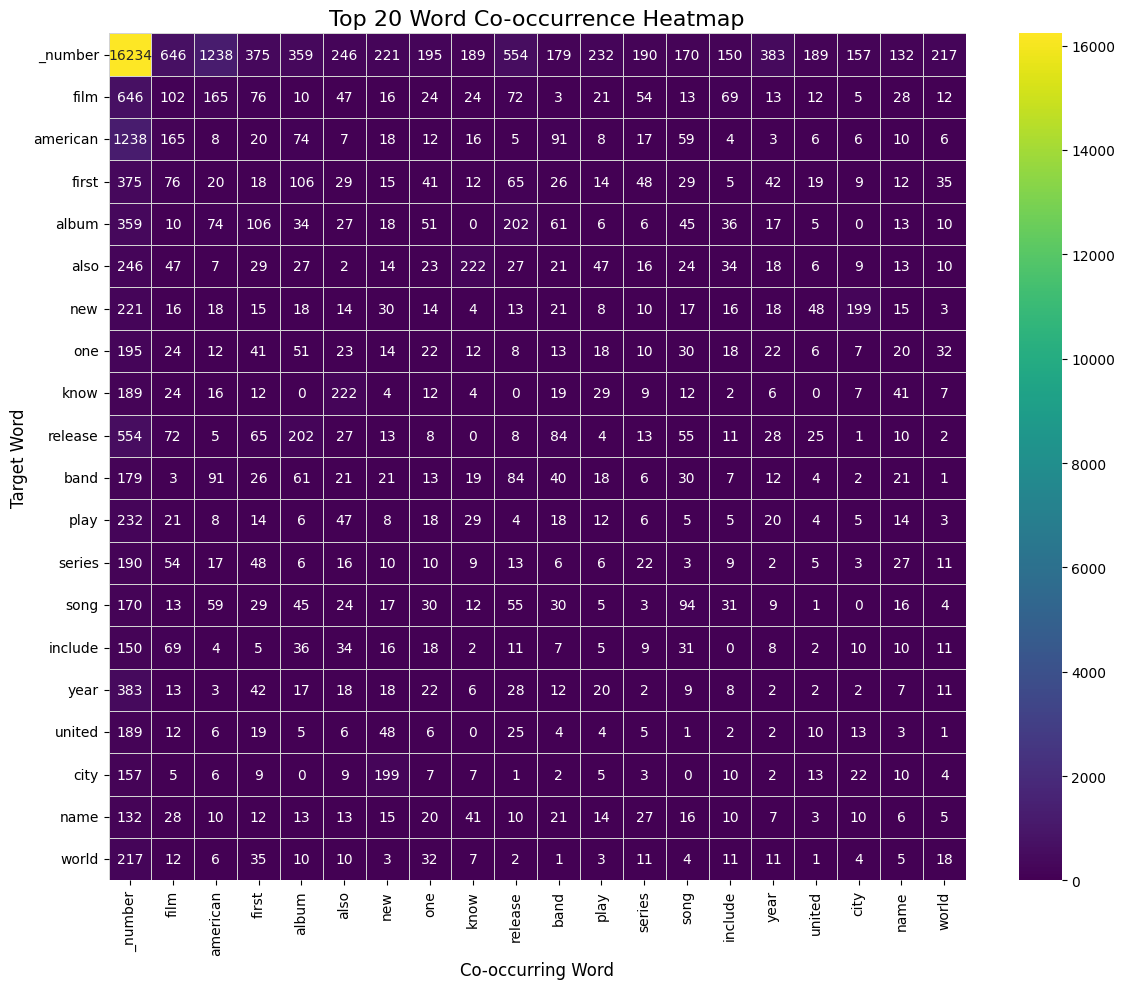

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Select a subset of the co_occurrence_matrix for visualization
subset_size = 20
co_occurrence_subset = co_occurrence_matrix.iloc[:subset_size, :subset_size]

# 3. Create a heatmap using sns.heatmap()
plt.figure(figsize=(12, 10))
sns.heatmap(
    co_occurrence_subset,
    annot=True,       # <-- להציג את המספרים
    cmap='viridis',
    fmt='d',          # 'd' כי מדובר במספרים שלמים
    linewidths=.5,    # Add lines between cells
    linecolor='lightgrey'
)

# 4. Set the title of the heatmap
plt.title(f'Top {subset_size} Word Co-occurrence Heatmap', fontsize=16)
plt.xlabel('Co-occurring Word', fontsize=12)
plt.ylabel('Target Word', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# 5. Display the plot
plt.tight_layout()
plt.show()



## Final Task

### Subtask:
Summarize the findings from the co-occurrence matrix analysis, highlighting any interesting word associations and their implications.


## Summary:

### Data Analysis Key Findings

*   **Data Preparation**:
    *   A total of 2,000 top words were extracted from the processed text data (`df_out`) to form the basis for co-occurrence analysis.
    *   The entire dataset, after processing, contained 324,044 tokens (`all_tokens_processed`).
*   **Co-occurrence Matrix Calculation**:
    *   A co-occurrence matrix was computed for the 2,000 top words using a sliding window of size 2 (meaning words within two positions left or right were considered co-occurring).
    *   The matrix quantified how often each pair of top words appeared together within the defined window.
    *   Initial observations from the matrix head indicated strong co-occurrences, such as `_number` appearing with `film` 646 times and `_number` with `american` 1,238 times, while `film` and `american` co-occurred 165 times.
*   **Visualization**:
    *   A heatmap visualizing the co-occurrence patterns of the top 20 words from the matrix was generated to offer a clear visual representation of their relationships.
    *   The heatmap allowed for easy identification of highly co-occurring word pairs (represented by warmer colors).
*   **Key Word Associations**:
    *   The term `_number` shows significantly high co-occurrence with various other words, suggesting it frequently appears alongside many other concepts in the text, possibly as a descriptor or identifier.
    *   Words like `film` and `american` also showed notable co-occurrences, indicating their contextual relationships within the dataset.

### Insights or Next Steps

*   The prevalence of `_number` in co-occurrence suggests a strong numerical or statistical context within the text. Further analysis could involve investigating the specific entities or contexts where `_number` is most frequently used to understand its role.
*   To gain deeper insights into topic modeling or semantic relationships, it would be beneficial to apply dimensionality reduction techniques (e.g., PCA, t-SNE) on the co-occurrence matrix or use it as input for clustering algorithms to identify groups of words that frequently appear together, thus representing distinct topics.


# Task
## Prepare Data for Unprocessed Co-occurrence

### Subtask:
Extract the list of top words from the `dfUnprossed` DataFrame, and flatten all tokens from the `dfUnprossed` text columns into a single list (`all_tokens_unprocessed`). This will ensure proper sequencing for co-occurrence analysis of the unprocessed data.

## Prepare Data for Unprocessed Co-occurrence

### Subtask:
Extract the list of top words from the `dfUnprossed` DataFrame, and flatten all tokens from the `dfUnprossed` text columns into a single list (`all_tokens_unprocessed`). This will ensure proper sequencing for co-occurrence analysis of the unprocessed data.


**Reasoning**:
To extract the top words from the unprocessed data, I need to flatten the tokenized sentences, count token frequencies, identify the most common words, create a DataFrame for these words, and then extract the words into a list, following the instructions provided.



## Prepare Data for Unprocessed Co-occurrence (All Words)

### Subtask:
Extract all unique words from the `dfUnprossed` DataFrame, along with their frequencies, to create `df_top_words_unprocessed` and `top_words_list_unprocessed`.


**Reasoning**:
To extract all unique words and their frequencies from `dfUnprossed`, I will first tokenize its text columns, flatten the resulting tokens, count their frequencies, create a DataFrame from these counts, and then extract the words into a list, as per the instructions.



In [3]:
from collections import Counter
import pandas as pd

# Assuming get_tokenized_sentences and text_cols are defined in previous cells.
# 1. Use the get_tokenized_sentences function to tokenize the text columns in dfUnprossed
print("Tokenizing dfUnprossed...")
tokenized_sentences_unprocessed = get_tokenized_sentences(dfUnprossed, text_cols)
print(f"Generated {len(tokenized_sentences_unprocessed)} tokenized sentences from dfUnprossed.")

# 2. Flatten the list of lists into a single list of all tokens
all_tokens_unprocessed = [token for sentence in tokenized_sentences_unprocessed for token in sentence]
print(f"Flattened into {len(all_tokens_unprocessed)} tokens for dfUnprossed.")

# 3. Calculate the frequency of each token
token_counts_unprocessed = Counter(all_tokens_unprocessed)

# 4. Create a pandas DataFrame from token_counts_unprocessed
df_top_words_unprocessed = pd.DataFrame(token_counts_unprocessed.most_common(), columns=['Word', 'Frequency'])
print("df_top_words_unprocessed created:")
display(df_top_words_unprocessed.head())

# 5. Extract the 'Word' column and convert it to a list
top_words_list_unprocessed = df_top_words_unprocessed['Word'].tolist()
print(f"Extracted {len(top_words_list_unprocessed)} unique words into top_words_list_unprocessed.")
print("First 10 words in top_words_list_unprocessed:", top_words_list_unprocessed[:10])

Tokenizing dfUnprossed...


NameError: name 'get_tokenized_sentences' is not defined

## Calculate Unprocessed Co-occurrence Matrix (All Words)

### Subtask:
Compute the co-occurrence matrix for all unique words from `top_words_list_unprocessed` based on `all_tokens_unprocessed` within the same defined window.


**Reasoning**:
Following the instructions, I will initialize a defaultdict for the co-occurrence matrix and a word-to-index map for `top_words_list_unprocessed`. Then, I will iterate through `all_tokens_unprocessed` to count co-occurrences within the defined window size, convert the result into a pandas DataFrame, and display its head to verify the structure.



In [1]:
from collections import defaultdict
import pandas as pd

# 1. Initialize co-occurrence matrix and word_to_index map for unprocessed data
co_occurrence_matrix_unprocessed_dict = defaultdict(lambda: defaultdict(int))
word_to_index_unprocessed = {word: i for i, word in enumerate(top_words_list_unprocessed)}

# 2. Define sliding window size (reusing the same as processed data)
# window_size is already defined from previous cells, ensuring consistency

print(f"Calculating co-occurrence matrix for unprocessed data with window size: {window_size}")

# 3. Iterate through all_tokens_unprocessed and count co-occurrences
for i, token in enumerate(all_tokens_unprocessed):
    if token in word_to_index_unprocessed: # Only consider tokens that are in our top_words_list_unprocessed
        target_word = token

        # Define the window for co-occurrence
        start = max(0, i - window_size)
        end = min(len(all_tokens_unprocessed), i + window_size + 1)

        for j in range(start, end):
            if i == j: # Skip the word itself
                continue

            co_occurring_word = all_tokens_unprocessed[j]
            if co_occurring_word in word_to_index_unprocessed: # Only count if co-occurring word is also in top_words_list_unprocessed
                co_occurrence_matrix_unprocessed_dict[target_word][co_occurring_word] += 1

print("Co-occurrence counting complete for unprocessed data. Converting to DataFrame...")

# 4. Convert co-occurrence counts into a pandas DataFrame
# Create an empty DataFrame with top_words_list_unprocessed as index and columns
co_occurrence_matrix_unprocessed = pd.DataFrame(0, index=top_words_list_unprocessed, columns=top_words_list_unprocessed)

# Populate the DataFrame from the dictionary
for word1, inner_dict in co_occurrence_matrix_unprocessed_dict.items():
    for word2, count in inner_dict.items():
        co_occurrence_matrix_unprocessed.loc[word1, word2] = count

# 5. Display the head of the co_occurrence_matrix_unprocessed
print("\nCo-occurrence Matrix for Unprocessed Data (first 5x5 rows/columns):")
display(co_occurrence_matrix_unprocessed.iloc[:5, :5])

NameError: name 'top_words_list_unprocessed' is not defined

**Reasoning**:
The previous code failed because 'top_words_list_unprocessed' was not defined. To fix this, I will re-include the necessary steps from the preceding cell (`ee7d5d59`) that compute 'all_tokens_unprocessed', 'token_counts_unprocessed', 'df_top_words_unprocessed', and 'top_words_list_unprocessed' at the beginning of the current code block. This ensures that all required variables are properly initialized before proceeding with the co-occurrence matrix calculation.



In [ ]:
from collections import defaultdict, Counter
import pandas as pd
from nltk.tokenize import word_tokenize # Assuming nltk is already downloaded

# Define get_tokenized_sentences if not guaranteed to be in current kernel state
# This function was defined in cell b6c972ec
def get_tokenized_sentences(dataframe, text_columns):
    all_tokenized_sentences = []
    for col in text_columns:
        for text_value in dataframe[col].dropna():
            if isinstance(text_value, str):
                all_tokenized_sentences.append(word_tokenize(text_value))
    return all_tokenized_sentences

# Re-create variables from previous cells (ee7d5d59 and its dependencies) for robustness
# Assuming dfUnprossed and text_cols are already defined from previous successful cells

print("Tokenizing dfUnprossed (re-calculating for robustness)...")
tokenized_sentences_unprocessed = get_tokenized_sentences(dfUnprossed, text_cols)
print(f"Generated {len(tokenized_sentences_unprocessed)} tokenized sentences from dfUnprossed.")

all_tokens_unprocessed = [token for sentence in tokenized_sentences_unprocessed for token in sentence]
print(f"Flattened into {len(all_tokens_unprocessed)} tokens for dfUnprossed.")

token_counts_unprocessed = Counter(all_tokens_unprocessed)
df_top_words_unprocessed = pd.DataFrame(token_counts_unprocessed.most_common(), columns=['Word', 'Frequency'])
top_words_list_unprocessed = df_top_words_unprocessed['Word'].tolist()
print(f"Re-extracted {len(top_words_list_unprocessed)} unique words into top_words_list_unprocessed.")


# 1. Initialize co-occurrence matrix and word_to_index map for unprocessed data
co_occurrence_matrix_unprocessed_dict = defaultdict(lambda: defaultdict(int))
word_to_index_unprocessed = {word: i for i, word in enumerate(top_words_list_unprocessed)}

# 2. Define sliding window size (reusing the same as processed data)
# window_size is already defined from previous cells, ensuring consistency
# If window_size is not defined for some reason, default it to 2
if 'window_size' not in locals() and 'window_size' not in globals():
    window_size = 2

print(f"Calculating co-occurrence matrix for unprocessed data with window size: {window_size}")

# 3. Iterate through all_tokens_unprocessed and count co-occurrences
for i, token in enumerate(all_tokens_unprocessed):
    if token in word_to_index_unprocessed: # Only consider tokens that are in our top_words_list_unprocessed
        target_word = token

        # Define the window for co-occurrence
        start = max(0, i - window_size)
        end = min(len(all_tokens_unprocessed), i + window_size + 1)

        for j in range(start, end):
            if i == j: # Skip the word itself
                continue

            co_occurring_word = all_tokens_unprocessed[j]
            if co_occurring_word in word_to_index_unprocessed: # Only count if co-occurring word is also in top_words_list_unprocessed
                co_occurrence_matrix_unprocessed_dict[target_word][co_occurring_word] += 1

print("Co-occurrence counting complete for unprocessed data. Converting to DataFrame...")

# 4. Convert co-occurrence counts into a pandas DataFrame
# Create an empty DataFrame with top_words_list_unprocessed as index and columns
co_occurrence_matrix_unprocessed = pd.DataFrame(0, index=top_words_list_unprocessed, columns=top_words_list_unprocessed)

# Populate the DataFrame from the dictionary
for word1, inner_dict in co_occurrence_matrix_unprocessed_dict.items():
    for word2, count in inner_dict.items():
        co_occurrence_matrix_unprocessed.loc[word1, word2] = count

# 5. Display the head of the co_occurrence_matrix_unprocessed
print("\nCo-occurrence Matrix for Unprocessed Data (first 5x5 rows/columns):")
display(co_occurrence_matrix_unprocessed.iloc[:5, :5])